In [1]:
import PIL
import gc
import torch
import torchvision
import os

import numpy as np
import matplotlib.pyplot as plt  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import Subset
from IPython.core.display import display, HTML
from numpy.random import RandomState
from wide_resnet import WideResNet
from auto_augment import AutoAugment, Cutout
from efficientnet_pytorch import EfficientNet
from cifar_loader import SmallSampleController


# display(HTML("<style>.container { width:40% !important; }</style>"))


In [2]:

def getAcc(preds,targets):
    return np.sum([1 if preds[i] == targets[i] else 0 for i in range(len(preds))])/len(preds)

def train(model, device, train_loader, optimizer, epoch, display=True):
    """
    Summary: Implements the training procedure for a given model
    == params ==
    model: the model to test
    device: cuda or cpu 
    optimizer: the optimizer for our training
    train_loader: dataloader for our train data
    display: output flag
    == output ==
    the mean train loss, the train accuracy
    """
    
    lossTracker = []
    
    targets=[]
    preds=[]
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        lossTracker.append(loss.detach())
        with torch.no_grad():
            pred = torch.argmax(output,1).cpu().numpy()
            preds.extend(pred)
            targets.extend(target.cpu().numpy())
        
    lossTracker = [x.item() for x in lossTracker]
    meanLoss = np.mean(lossTracker)
    accuracy = getAcc(preds,targets)
    if display:
        print('Train Epoch: {} [acc: {:.0f}%]\tLoss: {:.6f}'.format(
          epoch, 100. * accuracy, meanLoss))
        
    return accuracy, meanLoss



def test(model, device, test_loader,verbose=True):
    """
    Summary: Implements the testing procedure for a given model
    == params ==
    model: the model to test
    device: cuda or cpu 
    test_loader: dataloader for our test data
    verbose: output flag
    == output ==
    the mean test loss, the test accuracy
    """
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    meanLoss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if verbose: print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        mean_test_loss, correct, len(test_loader.dataset),
        accuracy))
        
    return accuracy, meanLoss


def checkTest(model,device,valSets,valTracker,latexTracker,epoch,
              model_name,optim_name,lr,totalTestSamples,seed,verbose=True):
    """
    Summary: checks the test accuracy, prints, and saves statistics
    """
    tempAcc = []
    tempLoss = []
    for val_loader in valSets:
        acc,loss = test(model, device, val_loader,verbose = False)
        tempAcc.append(acc)
        tempLoss.append(loss)
        
    meanAcc = np.mean(tempAcc)
    stdAcc = np.std(tempAcc)
    
    meanLoss = np.mean(tempLoss)
    if verbose:
        print('[Trained for {} epochs and tested on {} sets of 2000 images]\
        Avg Acc: {:.2f} +- {:.2f} , Avg Loss: {:.2f}'.format(
            epoch,VALIDATION_SET_NUM,meanAcc,stdAcc,meanLoss))
        
        
    tableRow = getLatexRow(architecture=model_name,epoch=epoch,accuracy=meanAcc,optim=optim_name,
                           lr=lr,totalTestSamples=totalTestSamples,dataAug="Nothing",
                           seed=seed,title=False)
    
    latexTracker.append(tableRow)
        
    valTracker["allLoss"].extend(tempLoss)
    valTracker["allAcc"].extend(tempAcc)
    valTracker["meanLoss"].append(meanLoss)
    valTracker["meanAcc"].append(meanAcc)
    valTracker["stdAcc"].append(stdAcc)





In [3]:
def getLatexRow(architecture,epoch,accuracy,optim,lr,
                totalTestSamples,dataAug,seed,title=False):
    """
    Summary: generates one row of latex for a results table
    """
    categories = ["Model","Epoch","Accuracy","Optimizer","lr","Test Sample Num",
                  "data augmentation","seed"]
    row = [str(architecture),str(epoch),str(round(accuracy,3)),str(optim),
           str(lr),str(totalTestSamples),str(dataAug),str(seed)]
    
    if title:
        c = "&".join(categories)
        r = "&".join(row)
        return "{}\\\\\n{}\\\\".format(c,r)
    else:
        r = "&".join(row)
        return "{}\\\\".format(r)
    
    
def plot(xlist,ylist,xlab,ylab,title,color,label,savedir=".",save=False):
    """
    Summary: plots the given list of numbers against its idices and 
    allows for high resolution saving
    """
    fig = plt.figure()
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.plot(xlist,ylist,color=color,marker=".",label=label)
    plt.legend()
    
    if save:
        if not os.path.isdir(savedir):
            os.mkdir(savedir)
        filepath = os.path.join(savedir,"{}".format(title))
        plt.savefig(filepath+".pdf")
        os.system("pdftoppm -png -r 300 {}.pdf {}.png".format(filepath,filepath))
        
    plt.show()
    
    

In [4]:
def getModel(model_name):
    if "wide" in model_name.lower():
        return WideResNet(28, 10, num_classes=10)
    elif "fix" in model_name.lower():
        return EfficientNet.from_pretrained(model_name) # change to not be pretrained
    
    
def getOptimizer128(optimizer_name,parameters):
    if "sgd" in  optimizer_name.lower():
        LR = 0.09
        optim = torch.optim.SGD(parameters, 
                                  lr=LR, momentum=0.9,
                                  weight_decay=0.0005)
        return optim, LR
    elif "adam" in optimizer_name.lower():
        LR = 0.001
        optim = torch.optim.Adam(parameters, 
                              lr=LR, weight_decay=0)
        return optim, LR
        
    

In [5]:
torch.cuda.empty_cache()
gc.collect()

OPTIM = "Adam"
MODEL = "WideResNet28"
EPOCH_NUM = 1000
TRAIN_SAMPLE_NUM = 100
VAL_SAMPLE_NUM = 2000
BATCH_SIZE = 128
VALIDATION_SET_NUM = 5
AUGMENT = True
VAL_DISPLAY_DIVISOR = 10
CIFAR_TRAIN = True

#cifar-10:
#mean = (0.4914, 0.4822, 0.4465)
#std = (0.247, 0.243, 0.261)


normalize = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                  std=[0.247, 0.243, 0.261])

# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                   std=[0.229, 0.224, 0.225])
if AUGMENT:
    dataAugmentation = [ 
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        AutoAugment(),
        Cutout()
    ]
    augment = "Crop,Flip,AutoAugment,Cutout"
else: 
    dataAugmentation = []
    augment = "Nothing"



transform_train = transforms.Compose(dataAugmentation + [transforms.ToTensor(), normalize]) 
transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same

cifar_train = datasets.CIFAR10(root='.',train=CIFAR_TRAIN, transform=transform_train, download=True)
cifar_val = datasets.CIFAR10(root='.',train=CIFAR_TRAIN, transform=transform_val, download=True)

ss = SmallSampleController(numClasses=10,trainSampleNum=TRAIN_SAMPLE_NUM, # abstract the data-loading procedure
                           valSampleNum=VAL_SAMPLE_NUM, batchSize=BATCH_SIZE, 
                           multiplier=VALIDATION_SET_NUM, trainDataset=cifar_train, 
                           valDataset=cifar_val)
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data, valSets, seed = ss.generateNewSet(device,valMultiplier = VALIDATION_SET_NUM) #Sample from datasets


model = getModel(MODEL).cuda()
optimizer,LR = getOptimizer128(OPTIM,model.parameters())

print(' => Total trainable parameters: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))        

trainTracker = {"meanLoss":[],"accuracy":[]}
valTracker = {"allLoss":[],"allAcc":[],"meanLoss":[],"meanAcc":[],"stdAcc":[]}
latexTracker = []

print("Begin Train for {} epochs".format(EPOCH_NUM))
for epoch in range(EPOCH_NUM):
    acc, loss = train(model, device, train_data[0], optimizer, epoch+1, display=True)
    trainTracker["meanLoss"].append(loss)
    trainTracker["accuracy"].append(acc)
    
    if (epoch+1) % VAL_DISPLAY_DIVISOR == 0:
        checkTest(model,device,valSets,valTracker,latexTracker,epoch+1,
              model_name=MODEL,optim_name=OPTIM,lr=LR,totalTestSamples=VAL_SAMPLE_NUM*VALIDATION_SET_NUM,
                  seed=seed,verbose=True)
        
          
        
        

Files already downloaded and verified
Files already downloaded and verified
Generated new permutation of the CIFAR train dataset with                 seed:1619927751, train sample num: 100, test sample num: 2000
 => Total trainable parameters: 36.48M
Begin Train for 1000 epochs
Train Epoch: 1 [acc: 12%]	Loss: 2.318227
Train Epoch: 2 [acc: 10%]	Loss: 2.585161
Train Epoch: 3 [acc: 7%]	Loss: 2.336824
Train Epoch: 4 [acc: 10%]	Loss: 2.540468
Train Epoch: 5 [acc: 18%]	Loss: 2.239249
Train Epoch: 6 [acc: 18%]	Loss: 2.136615
Train Epoch: 7 [acc: 17%]	Loss: 2.253949
Train Epoch: 8 [acc: 21%]	Loss: 2.182785
Train Epoch: 9 [acc: 25%]	Loss: 2.198506
Train Epoch: 10 [acc: 18%]	Loss: 2.336220


/home/benjamin/venv/torch11/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Trained for 10 epochs and tested on 5 sets of 2000 images]        Avg Acc: 11.76 +- 0.43 , Avg Loss: 3.07
Train Epoch: 11 [acc: 22%]	Loss: 2.171866
Train Epoch: 12 [acc: 23%]	Loss: 2.252431
Train Epoch: 13 [acc: 29%]	Loss: 2.001966
Train Epoch: 14 [acc: 24%]	Loss: 2.064332
Train Epoch: 15 [acc: 27%]	Loss: 2.079786
Train Epoch: 16 [acc: 25%]	Loss: 2.045937
Train Epoch: 17 [acc: 29%]	Loss: 2.013675
Train Epoch: 18 [acc: 22%]	Loss: 2.040868
Train Epoch: 19 [acc: 29%]	Loss: 1.932844
Train Epoch: 20 [acc: 28%]	Loss: 2.003943
[Trained for 20 epochs and tested on 5 sets of 2000 images]        Avg Acc: 10.80 +- 0.54 , Avg Loss: 5.40
Train Epoch: 21 [acc: 28%]	Loss: 2.003396
Train Epoch: 22 [acc: 30%]	Loss: 1.886040
Train Epoch: 23 [acc: 23%]	Loss: 1.941651
Train Epoch: 24 [acc: 35%]	Loss: 1.882723
Train Epoch: 25 [acc: 35%]	Loss: 1.847430
Train Epoch: 26 [acc: 32%]	Loss: 1.851506
Train Epoch: 27 [acc: 27%]	Loss: 1.864084
Train Epoch: 28 [acc: 27%]	Loss: 1.867459
Train Epoch: 29 [acc: 29%]	Los

Train Epoch: 164 [acc: 76%]	Loss: 0.735363
Train Epoch: 165 [acc: 79%]	Loss: 0.638239
Train Epoch: 166 [acc: 72%]	Loss: 0.900364
Train Epoch: 167 [acc: 70%]	Loss: 0.905043
Train Epoch: 168 [acc: 71%]	Loss: 0.910160
Train Epoch: 169 [acc: 73%]	Loss: 0.827067
Train Epoch: 170 [acc: 78%]	Loss: 0.714303
[Trained for 170 epochs and tested on 5 sets of 2000 images]        Avg Acc: 25.91 +- 0.96 , Avg Loss: 4.33
Train Epoch: 171 [acc: 80%]	Loss: 0.668548
Train Epoch: 172 [acc: 69%]	Loss: 0.948813
Train Epoch: 173 [acc: 73%]	Loss: 0.792086
Train Epoch: 174 [acc: 83%]	Loss: 0.551072
Train Epoch: 175 [acc: 76%]	Loss: 0.632624
Train Epoch: 176 [acc: 84%]	Loss: 0.599396
Train Epoch: 177 [acc: 70%]	Loss: 0.898430
Train Epoch: 178 [acc: 75%]	Loss: 0.739517
Train Epoch: 179 [acc: 71%]	Loss: 0.911709
Train Epoch: 180 [acc: 76%]	Loss: 0.716437
[Trained for 180 epochs and tested on 5 sets of 2000 images]        Avg Acc: 28.27 +- 0.50 , Avg Loss: 4.08
Train Epoch: 181 [acc: 80%]	Loss: 0.608940
Train Epoc

Train Epoch: 317 [acc: 90%]	Loss: 0.368522
Train Epoch: 318 [acc: 81%]	Loss: 0.481624
Train Epoch: 319 [acc: 90%]	Loss: 0.409879
Train Epoch: 320 [acc: 83%]	Loss: 0.470814
[Trained for 320 epochs and tested on 5 sets of 2000 images]        Avg Acc: 28.71 +- 0.97 , Avg Loss: 3.60
Train Epoch: 321 [acc: 91%]	Loss: 0.280377
Train Epoch: 322 [acc: 85%]	Loss: 0.478445
Train Epoch: 323 [acc: 88%]	Loss: 0.354771
Train Epoch: 324 [acc: 91%]	Loss: 0.304980
Train Epoch: 325 [acc: 85%]	Loss: 0.407721
Train Epoch: 326 [acc: 81%]	Loss: 0.555069
Train Epoch: 327 [acc: 87%]	Loss: 0.391211
Train Epoch: 328 [acc: 90%]	Loss: 0.301731
Train Epoch: 329 [acc: 84%]	Loss: 0.366204
Train Epoch: 330 [acc: 93%]	Loss: 0.276165
[Trained for 330 epochs and tested on 5 sets of 2000 images]        Avg Acc: 29.93 +- 0.89 , Avg Loss: 3.40
Train Epoch: 331 [acc: 84%]	Loss: 0.492614
Train Epoch: 332 [acc: 90%]	Loss: 0.313399
Train Epoch: 333 [acc: 90%]	Loss: 0.387869
Train Epoch: 334 [acc: 85%]	Loss: 0.360389
Train Epoc

Train Epoch: 470 [acc: 91%]	Loss: 0.185405
[Trained for 470 epochs and tested on 5 sets of 2000 images]        Avg Acc: 30.70 +- 0.92 , Avg Loss: 3.87
Train Epoch: 471 [acc: 94%]	Loss: 0.178111
Train Epoch: 472 [acc: 93%]	Loss: 0.191453
Train Epoch: 473 [acc: 91%]	Loss: 0.262724
Train Epoch: 474 [acc: 93%]	Loss: 0.197083
Train Epoch: 475 [acc: 89%]	Loss: 0.314796
Train Epoch: 476 [acc: 94%]	Loss: 0.235341
Train Epoch: 477 [acc: 93%]	Loss: 0.290894
Train Epoch: 478 [acc: 97%]	Loss: 0.175529
Train Epoch: 479 [acc: 96%]	Loss: 0.127451
Train Epoch: 480 [acc: 93%]	Loss: 0.242814
[Trained for 480 epochs and tested on 5 sets of 2000 images]        Avg Acc: 30.57 +- 0.91 , Avg Loss: 4.02
Train Epoch: 481 [acc: 87%]	Loss: 0.301035
Train Epoch: 482 [acc: 84%]	Loss: 0.394910
Train Epoch: 483 [acc: 94%]	Loss: 0.182558
Train Epoch: 484 [acc: 95%]	Loss: 0.201359
Train Epoch: 485 [acc: 92%]	Loss: 0.204956
Train Epoch: 486 [acc: 91%]	Loss: 0.252649
Train Epoch: 487 [acc: 95%]	Loss: 0.163734
Train Epoc

Train Epoch: 621 [acc: 93%]	Loss: 0.195562
Train Epoch: 622 [acc: 96%]	Loss: 0.150590
Train Epoch: 623 [acc: 96%]	Loss: 0.127709
Train Epoch: 624 [acc: 97%]	Loss: 0.089711
Train Epoch: 625 [acc: 95%]	Loss: 0.093238
Train Epoch: 626 [acc: 94%]	Loss: 0.166470
Train Epoch: 627 [acc: 94%]	Loss: 0.143946
Train Epoch: 628 [acc: 93%]	Loss: 0.197735
Train Epoch: 629 [acc: 95%]	Loss: 0.128131
Train Epoch: 630 [acc: 100%]	Loss: 0.047844
[Trained for 630 epochs and tested on 5 sets of 2000 images]        Avg Acc: 27.90 +- 1.28 , Avg Loss: 4.41
Train Epoch: 631 [acc: 97%]	Loss: 0.079537
Train Epoch: 632 [acc: 96%]	Loss: 0.186277
Train Epoch: 633 [acc: 96%]	Loss: 0.128256
Train Epoch: 634 [acc: 96%]	Loss: 0.148720
Train Epoch: 635 [acc: 96%]	Loss: 0.150971
Train Epoch: 636 [acc: 92%]	Loss: 0.278994
Train Epoch: 637 [acc: 94%]	Loss: 0.146016
Train Epoch: 638 [acc: 96%]	Loss: 0.123261
Train Epoch: 639 [acc: 95%]	Loss: 0.148278
Train Epoch: 640 [acc: 97%]	Loss: 0.098876
[Trained for 640 epochs and tes

Train Epoch: 774 [acc: 98%]	Loss: 0.073615
Train Epoch: 775 [acc: 94%]	Loss: 0.163232
Train Epoch: 776 [acc: 96%]	Loss: 0.088423
Train Epoch: 777 [acc: 91%]	Loss: 0.198803
Train Epoch: 778 [acc: 96%]	Loss: 0.112472
Train Epoch: 779 [acc: 96%]	Loss: 0.151091
Train Epoch: 780 [acc: 93%]	Loss: 0.169689
[Trained for 780 epochs and tested on 5 sets of 2000 images]        Avg Acc: 30.14 +- 1.01 , Avg Loss: 4.45
Train Epoch: 781 [acc: 97%]	Loss: 0.082984
Train Epoch: 782 [acc: 97%]	Loss: 0.095569
Train Epoch: 783 [acc: 98%]	Loss: 0.091798
Train Epoch: 784 [acc: 98%]	Loss: 0.098061
Train Epoch: 785 [acc: 96%]	Loss: 0.100267
Train Epoch: 786 [acc: 94%]	Loss: 0.195727
Train Epoch: 787 [acc: 94%]	Loss: 0.129373
Train Epoch: 788 [acc: 97%]	Loss: 0.126609
Train Epoch: 789 [acc: 96%]	Loss: 0.128138
Train Epoch: 790 [acc: 93%]	Loss: 0.180965
[Trained for 790 epochs and tested on 5 sets of 2000 images]        Avg Acc: 28.96 +- 0.81 , Avg Loss: 4.79
Train Epoch: 791 [acc: 97%]	Loss: 0.109110
Train Epoc

Train Epoch: 927 [acc: 98%]	Loss: 0.119815
Train Epoch: 928 [acc: 96%]	Loss: 0.103258
Train Epoch: 929 [acc: 98%]	Loss: 0.056749
Train Epoch: 930 [acc: 96%]	Loss: 0.075321
[Trained for 930 epochs and tested on 5 sets of 2000 images]        Avg Acc: 30.35 +- 1.34 , Avg Loss: 3.75
Train Epoch: 931 [acc: 98%]	Loss: 0.128448
Train Epoch: 932 [acc: 98%]	Loss: 0.064565
Train Epoch: 933 [acc: 98%]	Loss: 0.070303
Train Epoch: 934 [acc: 99%]	Loss: 0.046251
Train Epoch: 935 [acc: 97%]	Loss: 0.108142
Train Epoch: 936 [acc: 100%]	Loss: 0.015743
Train Epoch: 937 [acc: 97%]	Loss: 0.095823
Train Epoch: 938 [acc: 98%]	Loss: 0.049978
Train Epoch: 939 [acc: 97%]	Loss: 0.100573
Train Epoch: 940 [acc: 95%]	Loss: 0.115577
[Trained for 940 epochs and tested on 5 sets of 2000 images]        Avg Acc: 31.94 +- 0.91 , Avg Loss: 3.90
Train Epoch: 941 [acc: 96%]	Loss: 0.069384
Train Epoch: 942 [acc: 96%]	Loss: 0.122977
Train Epoch: 943 [acc: 98%]	Loss: 0.072646
Train Epoch: 944 [acc: 96%]	Loss: 0.109296
Train Epo

In [6]:
dirname = latexTracker[-1][:-2] 

def writeTex(latexTracker,dirname):
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
        
    f= open(os.path.join(dirname,"latexTable.txt"),"w")
    for x in latexTracker:
        f.write(x)
    f.close()

writeTex(latexTracker,dirname)

for x in latexTracker:
    print(x)

WideResNet28&10&11.76&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&20&10.8&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&30&16.91&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&40&23.51&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&50&23.15&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&60&23.99&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&70&20.98&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&80&24.82&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&90&23.41&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&100&25.41&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&110&27.06&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&120&26.58&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&130&27.51&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&140&23.86&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&150&29.77&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&160&24.13&Adam&0.001&10000&Nothing&1619927751\\
WideResNet28&170&25.91&Adam&0.001&

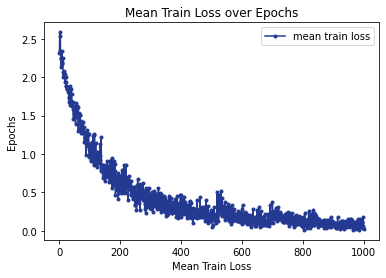

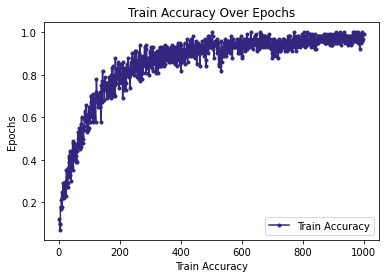

In [7]:

epochList = [x+1 for x in range(len(trainTracker["meanLoss"]))]

plot(xlist=epochList,ylist=trainTracker["meanLoss"],xlab="Mean Train Loss",
    ylab="Epochs",title="Mean Train Loss over Epochs",
    color="#243A92",label="mean train loss",savedir=dirname,save=True)

plot(xlist=epochList,ylist=trainTracker["accuracy"],xlab="Train Accuracy",
    ylab="Epochs",title="Train Accuracy Over Epochs",
    color="#34267E",label="Train Accuracy",savedir=dirname,save=True)

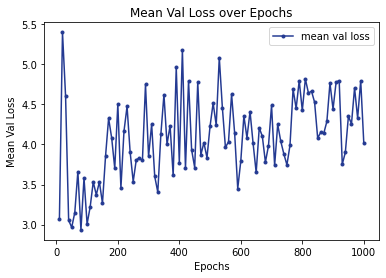

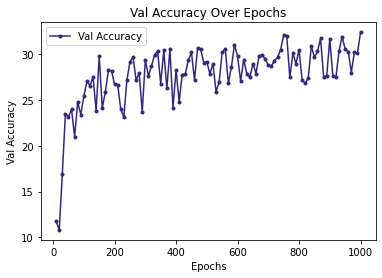

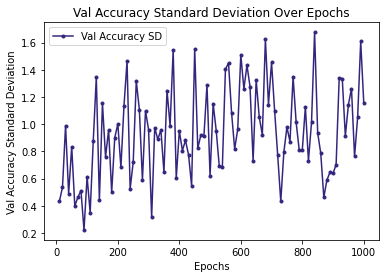

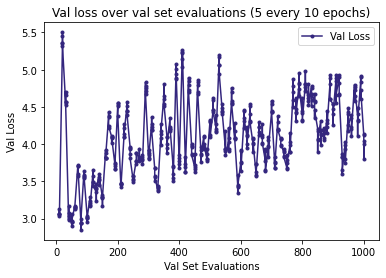

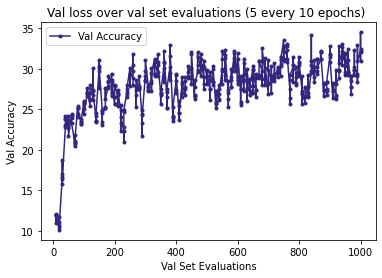

In [8]:

epochList = [VAL_DISPLAY_DIVISOR*(x+1) for x in range(len(valTracker["meanLoss"]))]

plot(xlist=epochList,ylist=valTracker["meanLoss"],xlab="Epochs",
    ylab="Mean Val Loss",title="Mean Val Loss over Epochs",
    color="#243A92",label="mean val loss",savedir=dirname,save=True)

plot(xlist=epochList,ylist=valTracker["meanAcc"],xlab="Epochs",
    ylab="Val Accuracy",title="Val Accuracy Over Epochs",
    color="#34267E",label="Val Accuracy",savedir=dirname,save=True)

plot(xlist=epochList,ylist=valTracker["stdAcc"],xlab="Epochs",
    ylab="Val Accuracy Standard Deviation",title="Val Accuracy Standard Deviation Over Epochs",
    color="#34267E",label="Val Accuracy SD",savedir=dirname,save=True)


valSetEvalCount = VAL_DISPLAY_DIVISOR * EPOCH_NUM * VALIDATION_SET_NUM
epochList = [VAL_DISPLAY_DIVISOR*(x+1) for x in range(len(valTracker["meanLoss"]))\
             for y in range(VALIDATION_SET_NUM)]


plot(xlist=epochList,ylist=valTracker["allLoss"],xlab="Val Set Evaluations",
    ylab="Val Loss",title="Val loss over val set evaluations ({} \
every {} epochs)".format(VALIDATION_SET_NUM,VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Loss",savedir=dirname,save=True)

plot(xlist=epochList,ylist=valTracker["allAcc"],xlab="Val Set Evaluations",
    ylab="Val Accuracy",title="Val loss over val set evaluations ({} \
every {} epochs) ".format(VALIDATION_SET_NUM,VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Accuracy",savedir=dirname,save=True)